<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [162]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off or in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [163]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-11-22 14:32:12--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.09s   

2020-11-22 14:32:13 (263 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [164]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [165]:
df.shape

(346, 10)

### Convert to date time object 

In [166]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [167]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [168]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

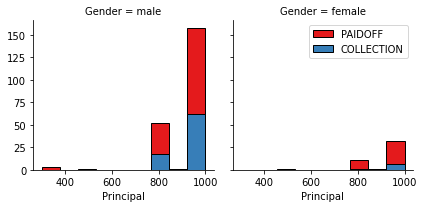

In [169]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

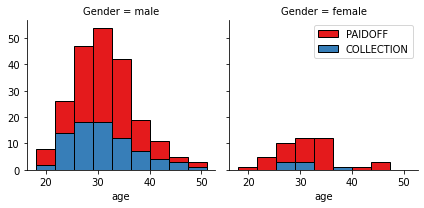

In [170]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

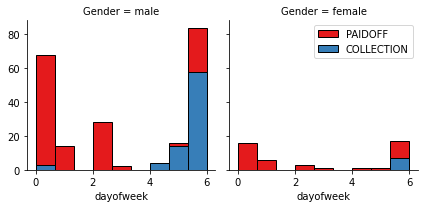

In [171]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [172]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [173]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [174]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [175]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [176]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [177]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [178]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [179]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [180]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, jaccard_score

In [182]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [183]:
k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=7)

In [184]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [185]:
print("Train set Accuracy = ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy = ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy =  0.8079710144927537
Test set Accuracy =  0.7857142857142857


In [186]:
Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       , 0.68571429,
       0.72857143, 0.72857143, 0.72857143, 0.7       , 0.68571429,
       0.71428571, 0.68571429, 0.7       , 0.7       , 0.72857143,
       0.71428571, 0.77142857, 0.68571429, 0.78571429, 0.75714286,
       0.78571429, 0.74285714, 0.78571429, 0.78571429, 0.78571429,
       0.75714286, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.77142857, 0.77142857, 0.77142857, 0.78571429, 0.77142857,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
       0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571

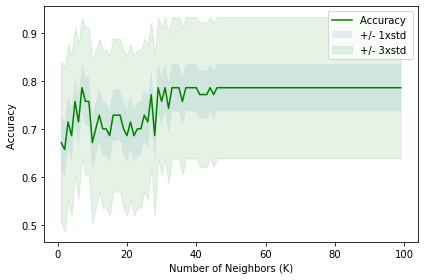

The best accuracy was  0.7857142857142857 with k= 7


In [187]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was ", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [188]:
print( "The best accuracy was ", mean_acc.max(), "with k=", mean_acc.argmax()+1)
print("Train set Accuracy = ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy = ", metrics.accuracy_score(y_test, yhat))

# calc F1 and Jacard
f1_score = f1_score(y_test, yhat, average='weighted') 
jaccard_score = jaccard_score(y_test, yhat, pos_label='PAIDOFF')

print("Avg F1-score = %.4f" % f1_score)
print("Jaccard score = %.4f" % jaccard_score)

The best accuracy was  0.7857142857142857 with k= 7
Train set Accuracy =  0.7427536231884058
Test set Accuracy =  0.7857142857142857
Avg F1-score = 0.6914
Jaccard score = 0.7857


# Decision Tree

In [189]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_score
from sklearn import metrics

In [190]:
# Split data set into train/testing sets: train X,y and test X,y
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
print('X training set shape: ' + str(X_trainset.shape))
print('y training set shape: ' + str(y_trainset.shape))
print('X testing set shape: ' + str(X_testset.shape))
print('y testing set shape: ' + str(y_testset.shape))

X training set shape: (242, 8)
y training set shape: (242,)
X testing set shape: (104, 8)
y testing set shape: (104,)


In [191]:
# Create instance of decision tree classifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [192]:
# Train
loanTree.fit(X_trainset, y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [193]:
# Prediction
predTree = loanTree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']


[Text(146.475, 195.696, 'X[4] <= -0.188\nentropy = 0.801\nsamples = 242\nvalue = [59, 183]'),
 Text(62.775000000000006, 152.208, 'X[7] <= 0.14\nentropy = 0.139\nsamples = 102\nvalue = [2, 100]'),
 Text(41.85, 108.72, 'entropy = 0.0\nsamples = 60\nvalue = [0, 60]'),
 Text(83.7, 108.72, 'X[2] <= 1.254\nentropy = 0.276\nsamples = 42\nvalue = [2, 40]'),
 Text(41.85, 65.232, 'X[2] <= -0.736\nentropy = 0.179\nsamples = 37\nvalue = [1, 36]'),
 Text(20.925, 21.744, 'entropy = 0.503\nsamples = 9\nvalue = [1, 8]'),
 Text(62.775000000000006, 21.744, 'entropy = 0.0\nsamples = 28\nvalue = [0, 28]'),
 Text(125.55000000000001, 65.232, 'X[2] <= 1.42\nentropy = 0.722\nsamples = 5\nvalue = [1, 4]'),
 Text(104.625, 21.744, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(146.475, 21.744, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(230.175, 152.208, 'X[1] <= -1.46\nentropy = 0.975\nsamples = 140\nvalue = [57, 83]'),
 Text(209.25, 108.72, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(25

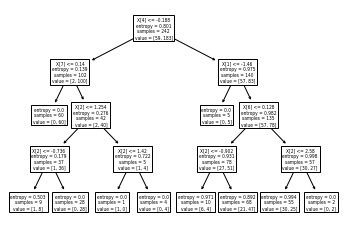

In [194]:
# Issues wit conda instal of plotting example from course
# here is a more basic plot of the decision tree...
from sklearn.datasets import load_iris
from sklearn import tree
tree.plot_tree(loanTree)

In [195]:
# Evaluation
print("Decision Tree Accuracy = ", metrics.accuracy_score(y_testset, predTree))

# calc F1 and Jacard
f1_score = f1_score(y_testset, predTree, average='weighted') 
jaccard_score = jaccard_score(y_testset, predTree, pos_label='PAIDOFF')

print("Avg F1-score = %.4f" % f1_score)
print("Jaccard score = %.4f" % jaccard_score)

Decision Tree Accuracy =  0.6538461538461539
Avg F1-score = 0.6667
Jaccard score = 0.6044


# Support Vector Machine

In [196]:
# Imports
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score

In [197]:
# Modelling
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [198]:
# Prediction
yhat_SVM = clf.predict(X_test)
yhat_SVM [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [199]:
# Evaluation
# calc F1 and Jacard
f1_score = f1_score(y_test, yhat_SVM, average='weighted') 
jaccard_score = jaccard_score(y_test, yhat_SVM, pos_label='PAIDOFF')
print("Avg F1-score = %.4f" % f1_score)
print("Jaccard score = %.4f" % jaccard_score)

Avg F1-score = 0.7276
Jaccard score = 0.7273


# Logistic Regression

In [200]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [201]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, f1_score, jaccard_score

In [202]:
# Modelling
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)

In [203]:
# Prediction
yhat_LR = LR.predict(X_test)
yhat_LR_prob = LR.predict_proba(X_test)

In [204]:
# Evaluation
# calc F1, Jacard and Log Loss 
f1_score = f1_score(y_test, yhat_LR, average='weighted') 
jaccard_score = jaccard_score(y_test, yhat_LR, pos_label='PAIDOFF')
log_loss_score = log_loss(y_test, yhat_LR_prob)

print("Avg F1-score = %.4f" % f1_score)
print("Jaccard score = %.4f" % jaccard_score)
print("Log Loss score = %.4f" % log_loss_score)

Avg F1-score = 0.6671
Jaccard score = 0.6765
Log Loss score = 0.5772


# Model Evaluation using Test set

In [205]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [206]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-11-22 14:33:38--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-11-22 14:33:39 (51.2 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [207]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [208]:
# convert datetime format
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
# convert days of week
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# convert gender to int
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1], inplace=True)
# assign numeric values to education catogories
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
Feature_2 = test_df[['Principal', 'terms', 'age', 'Gender', 'weekend']]
Feature_2 = pd.concat([Feature_2,pd.get_dummies(test_df['education'])], axis=1)
# drop master column
Feature_2.drop(['Master or Above'], axis = 1, inplace=True)

X_2 = Feature_2
y_2 = test_df['loan_status'].values
X_2 = preprocessing.StandardScaler().fit(X_2).transform(X_2)

In [209]:
# Jaccard Scores
# K nearest neighbor
KNN_Jaccard = jaccard_score(y_2, neigh.predict(X_2), pos_label='PAIDOFF')
print("KNN Jaccard =", KNN_Jaccard)
# Decision Tree
DT_Jaccard = jaccard_score(y_2, loanTree.predict(X_2), pos_label='PAIDOFF')
print("Decision Tree Jaccard =", DT_Jaccard)
# SVM
SVM_Jaccard = jaccard_score(y_2, clf.predict(X_2), pos_label='PAIDOFF')
print("SVM Jaccard =", SVM_Jaccard)
# Logistic Regression
LR_Jac = jaccard_score(y_2, LR.predict(X_2), pos_label='PAIDOFF')
print("Logistic Regression Jaccard =", LR_Jac, "\n")

# F1 Scores
# K nearest neighbor
KNN_F1 = f1_score(y_2, neigh.predict(X_2), average='weighted')
print("KNN F1-score =", KNN_F1)
# Decision Tree
DT_F1 = f1_score(y_2, loanTree.predict(X_2), average='weighted')
print ("Decision Tree F1-score =", DT_F1)
# SVM
SVM_F1 = f1_score(y_2, clf.predict(X_2), average='weighted')
print("SVM F1-score =", SVM_F1)
# Logistic Regression
LR_F1 = f1_score(y_2, LR.predict(X_2), average='weighted')
print("Logistic Regression F1-score =", LR_F1, "\n")

# LogLoss Score
# Logistic Regression
LR_logloss = log_loss(y_2, LR.predict_proba(X_2))
print("Logistic Regression LogLoss =", LR_logloss)

KNN Jaccard = 0.7407407407407407
Decision Tree Jaccard = 0.7333333333333333
SVM Jaccard = 0.78
Logistic Regression Jaccard = 0.7358490566037735 

KNN F1-score = 0.6304176516942475
Decision Tree F1-score = 0.7823361823361823
SVM F1-score = 0.7583503077293734
Logistic Regression F1-score = 0.6604267310789049 

Logistic Regression LogLoss = 0.5672153379912981


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.74    | 0.63     | NA      |
| Decision Tree      | 0.73    | 0.78     | NA      |
| SVM                | 0.78    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.66     | 0.57    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>